In [ ]:
#Input : AAPL - 2018 - OHLCV-SC
#Output: Predicted Stock Price Using Sentiment Score
#Model : LSTM

In [ ]:

import pandas as pd
df = pd.read_csv('/content/drive/My Drive/data_2018.csv')
print(df.head())


   Unnamed: 0    open    high     low   close      volume  Average Score
0  2018-12-31  158.53  159.36  156.48  157.74  35003466.0       0.253560
1  2018-12-28  157.50  158.52  154.55  156.23  42291424.0       0.223373
2  2018-12-27  155.84  156.77  150.07  156.15  53117065.0       0.216067
3  2018-12-26  148.30  157.23  146.72  157.17  58582544.0       0.238014
4  2018-12-24  148.15  151.55  146.59  146.83  37169232.0       0.182593


In [ ]:
df = df.rename(columns={'Unnamed: 0': 'date'})


In [ ]:
df.head()

,date,open,high,low,close,volume,Average Score
0,2018-12-31,158.53,159.36,156.48,157.74,35003466.0,0.253560
1,2018-12-28,157.50,158.52,154.55,156.23,42291424.0,0.223373
2,2018-12-27,155.84,156.77,150.07,156.15,53117065.0,0.216067
3,2018-12-26,148.30,157.23,146.72,157.17,58582544.0,0.238014
4,2018-12-24,148.15,151.55,146.59,146.83,37169232.0,0.182593


In [ ]:
df = df.sort_values(by='date')

print(df.head())


           date    open    high     low   close      volume  Average Score
250  2018-01-02  170.16  172.30  169.26  172.26  25048048.0       0.325566
249  2018-01-03  172.53  174.55  171.96  172.23  28819653.0       0.256721
248  2018-01-04  172.54  173.47  172.08  173.03  22211345.0       0.330698
247  2018-01-05  173.44  175.37  173.05  175.00  23016177.0       0.187864
246  2018-01-08  174.35  175.61  173.93  174.35  20134092.0       0.235286


In [ ]:
df = df.rename(columns={'Average Score': 'daily_avg_sentiment_score'})


In [ ]:
df.head()

,date,open,high,low,close,volume,daily_avg_sentiment_score
250,2018-01-02,170.16,172.30,169.26,172.26,25048048.0,0.325566
249,2018-01-03,172.53,174.55,171.96,172.23,28819653.0,0.256721
248,2018-01-04,172.54,173.47,172.08,173.03,22211345.0,0.330698
247,2018-01-05,173.44,175.37,173.05,175.00,23016177.0,0.187864
246,2018-01-08,174.35,175.61,173.93,174.35,20134092.0,0.235286


In [ ]:
df.tail()

,date,open,high,low,close,volume,daily_avg_sentiment_score
246,2018-12-24,0.000000,0.000000,0.000000,0.000000,0.294403,0.386664
247,2018-12-26,0.001815,0.069336,0.001563,0.121305,0.550154,0.563218
248,2018-12-27,0.093065,0.063721,0.041832,0.109338,0.484877,0.493304
249,2018-12-28,0.113155,0.085083,0.095685,0.110277,0.355580,0.516578
250,2018-12-31,0.125620,0.095337,0.118884,0.127992,0.268536,0.612742


In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam


# Use only numeric columns for training
feature_cols = ["open", "high", "low", "close", "volume", "daily_avg_sentiment_score"]
data = df[feature_cols].values

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# --- Step 2: Create sequences ---
window_size = 10  # use past 10 days to predict next day
X = []
y = []

for i in range(window_size, len(scaled_data)):
    X.append(scaled_data[i-window_size:i])
    y.append(scaled_data[i, 3])  # index 3 is 'close'

X = np.array(X)
y = np.array(y)

# --- Step 3: Train-test split ---
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# --- Step 4: Build and train LSTM ---
model = Sequential()
model.add(LSTM(units=50, return_sequences=False, input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test), verbose=0)

# Evaluate the model
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)

train_loss, test_loss

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


(0.002726094564422965, 0.009349808096885681)

In [ ]:
predicted_close = model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


In [ ]:
# Invert scaling to get actual close price predictions
full_close_scaled = scaled_data[:, 3].reshape(-1, 1)  # 'close' column only
dummy_input = np.zeros((len(predicted_close), scaled_data.shape[1]))
dummy_input[:, 3] = predicted_close[:, 0]
predicted_close_actual = scaler.inverse_transform(dummy_input)[:, 3]

In [ ]:
dummy_true = np.zeros((len(y_test), scaled_data.shape[1]))
dummy_true[:, 3] = y_test
true_close_actual = scaler.inverse_transform(dummy_true)[:, 3]

In [ ]:
import matplotlib.pyplot as plt

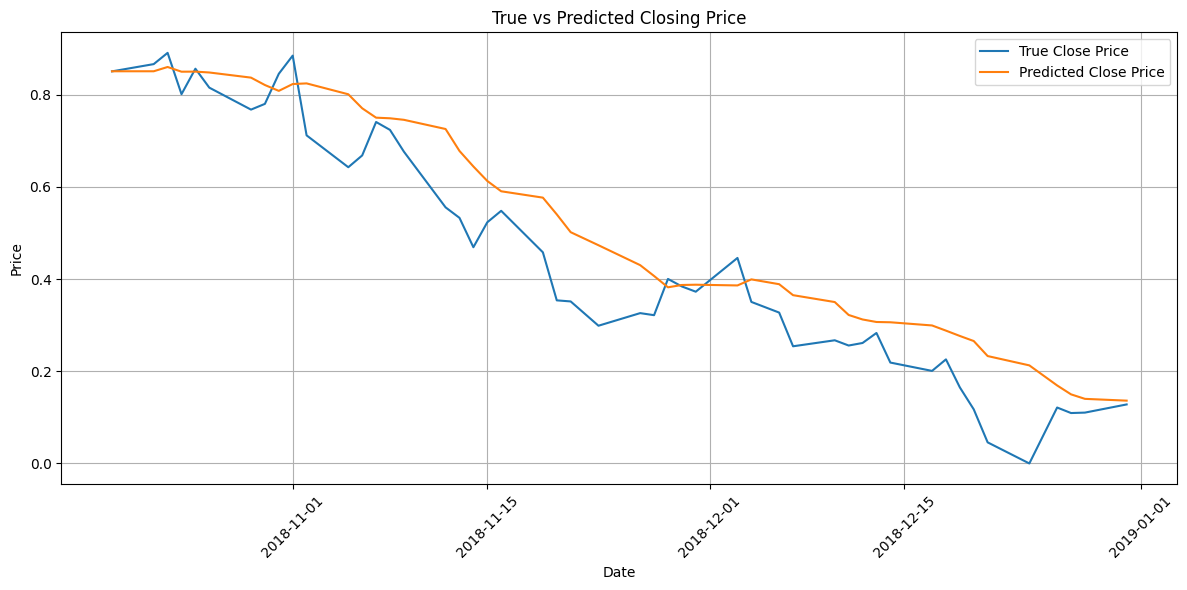

In [ ]:
# plt.figure(figsize=(12,6))
# plt.plot(df['date'].values[-len(y_test):], true_close_actual, label='True Close Price')
# plt.plot(df['date'].values[-len(y_test):], predicted_close_actual, label='Predicted Close Price')
# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.title('True vs Predicted Closing Price')
# plt.legend()
# plt.grid(True)
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

In [ ]:
results_df = pd.DataFrame({'True Close Price': true_close_actual, 'Predicted Close Price': predicted_close_actual, 'Predicted Close Price WS': predicted_close_actual_WS})

# Display the table
results_df


In [ ]:
# Save the model
model.save("lstm_stock_model.h5")

In [ ]:
from keras.saving import save_model
save_model(model, "lstm_stock_model.keras")

In [ ]:
signals = (predicted_close_actual[1:] > predicted_close_actual[:-1]).astype(int)
# 1 = buy, 0 = sell/hold
print("Buy/Sell Signals (1=Buy, 0=Hold/Sell):")
print(signals[:20].flatten())

Buy/Sell Signals (1=Buy, 0=Hold/Sell):
[0 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0]


In [ ]:
#todo : get predictions without sentiment score
#show : effect of sentiment on stock price prediction